Load the Iris dataset and whiten the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

iris = datasets.load_iris()
train_x, classes = iris.data, iris.target

# whiten features
train_x -= np.mean(train_x, axis=0)
train_x /= np.std(train_x, axis=0) + 1e-8

# convert target to one hot vectors
train_y = np.zeros((150, 3))
train_y[np.arange(150), classes] = 1

Train a fuzzy classifier for analysis later.

Using TensorFlow backend.


150/150 [==============================] - 0s 226us/step
[0.026712746024131775, 0.9866666642824808]


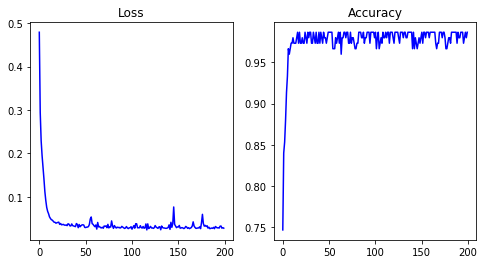

In [2]:
import keras
import keras.layers as layers
import keras.backend as K
from model import LogGaussMF


def train_model():
    model = keras.Sequential([
        LogGaussMF(3, input_shape=(4,)),
        layers.Lambda(lambda x: K.sum(x, axis=-1)),
        layers.Activation("softmax")
    ])
    
    model.compile(
        optimizer=keras.optimizers.adam(lr=0.03),
        loss="binary_crossentropy",
        metrics=[keras.metrics.categorical_accuracy])

    # train the model
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=16,
        epochs=200,
        verbose=0,
        shuffle=True)
    
    print(model.evaluate(train_x, train_y))
    
    # plot the loss and accuracy
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
    axes[0].set_title("Loss")
    axes[0].plot(history.history["loss"], c="b")

    axes[1].set_title("Accuracy")
    axes[1].plot(history.history["categorical_accuracy"], c="b")

    return model


model = train_model()

This function finds the representative for each class. The representative is the training example that maximizes the firing strength of that classes rule rule.

In [3]:
def find_representatives(model):
    pred_y = model.predict(train_x)
    
    medoid_idxs = []
    for i in range(3):
        medoid_idxs.append(np.argmax(pred_y[:,i]))
    
    return train_x[medoid_idxs]


medoids = find_representatives(model)

The code in this section is for getting the intermediate tensors from iNNvestigate. There appears to be a bug in the function "\_handle_debug_output" that causes the program to crash when storing intermediate values of the neural network analysis. The function can be temporarily patched, until the library is updated as is done below.

In [4]:
import innvestigate
from keras.models import Model


def _handle_debug_output_patched(self, debug_values):
    
    if self._reverse_check_min_max_values:
        indices = self._debug_tensors_indices["min"]
        tmp = debug_values[indices[0]:indices[1]]
        tmp = sorted([(self._reverse_tensors_mapping[i], v)
                      for i, v in enumerate(tmp)])
        print("Minimum values in tensors: "
              "((NodeID, TensorID), Value) - {}".format(tmp))

        indices = self._debug_tensors_indices["max"]
        tmp = debug_values[indices[0]:indices[1]]
        tmp = sorted([(self._reverse_tensors_mapping[i], v)
                      for i, v in enumerate(tmp)])
        print("Maximum values in tensors: "
              "((NodeID, TensorID), Value) - {}".format(tmp))

    if self._reverse_check_finite:
        indices = self._debug_tensors_indices["finite"]
        tmp = debug_values[indices[0]:indices[1]]
        nfinite_tensors = np.flatnonzero(np.asarray(tmp) > 0)

        if len(nfinite_tensors) > 0:
            nfinite_tensors = sorted([self._reverse_tensors_mapping[i]
                                      for i in nfinite_tensors])
            print("Not finite values found in following nodes: "
                  "(NodeID, TensorID) - {}".format(nfinite_tensors))

    if self._reverse_keep_tensors:
        indices = self._debug_tensors_indices["keep"]
        tmp = debug_values[indices[0]:indices[1]]
        # added: key=lambda x: x[0]
        tmp = sorted([(self._reverse_tensors_mapping[i], v)
                      for i, v in enumerate(tmp)], key=lambda x: x[0])
    self._reversed_tensors = tmp


def create_analyzer(name, model, **kwargs):
    analyzer = innvestigate.create_analyzer(
        name, model, **kwargs)
    analyzer._handle_debug_output = lambda x: _handle_debug_output_patched(analyzer, x)
    return analyzer
   

model_wo_softmax = Model(model.inputs, [model.layers[-2].output])
analyzer = create_analyzer( 
    "gradient", 
    model_wo_softmax,
    neuron_selection_mode="index",
    allow_lambda_layers=True,
    reverse_keep_tensors=True)

for i in range(3):
    print(analyzer.analyze(np.reshape(medoids[i], (1,-1)), i))
    for x in filter(lambda x: x[0][0] >= 0, analyzer._reversed_tensors):
        print(x[1])
    print()

[[ 0.6412339  -0.14651312 -0.5086592  -1.163646  ]]
[[[1. 1. 1. 1.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
[[1. 0. 0.]]

[[ 2.3218846  2.4583893 -3.3971758 -2.464064 ]]
[[[0. 0. 0. 0.]
  [1. 1. 1. 1.]
  [0. 0. 0. 0.]]]
[[0. 1. 0.]]

[[ 0.02842956 -5.556132    3.6764874   0.96595174]]
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [1. 1. 1. 1.]]]
[[0. 0. 1.]]



A fuzzy model with a single layer for feature extraction is trained below for later analysis.

150/150 [==============================] - 0s 310us/step
[0.02071162320594643, 0.9866666642824808]


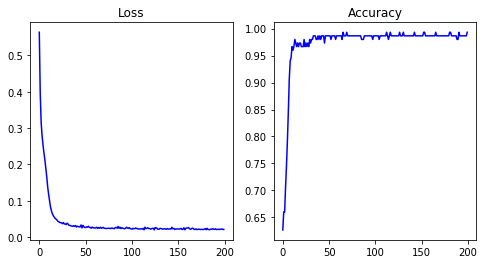

In [5]:
def train_deep_model():
    model = keras.Sequential([
        layers.Dense(4, activation="relu", input_shape=(4,)),
        LogGaussMF(3),
        layers.Lambda(lambda x: K.sum(x, axis=-1)),
        layers.Activation("softmax")
    ])
    
    model.compile(
        optimizer=keras.optimizers.adam(lr=0.01),
        loss="binary_crossentropy",
        metrics=[keras.metrics.categorical_accuracy])

    # train the model
    history = model.fit(
        x=train_x,
        y=train_y,
        batch_size=16,
        epochs=200,
        verbose=0,
        shuffle=True)
    
    print(model.evaluate(train_x, train_y))
    
    # plot the loss and accuracy
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
    axes[0].set_title("Loss")
    axes[0].plot(history.history["loss"], c="b")

    axes[1].set_title("Accuracy")
    axes[1].plot(history.history["categorical_accuracy"], c="b")

    return model


deep_model = train_deep_model()

This function analyzes the representatives for each class. Currently it just prints the tensors' value to stdout.

In [6]:
def analyze_representatives(model, name="guided_backprop"):
    model_wo_softmax = Model(model.inputs, [model.layers[-2].output])
    analyzer = create_analyzer( 
        name, 
        model_wo_softmax,
        neuron_selection_mode="index",
        allow_lambda_layers=True,
        reverse_keep_tensors=True)

    medoids = find_representatives(model)
    for i in range(3):
        print("Medoid {}:".format(i))
        print(analyzer.analyze(np.reshape(medoids[i], (1,-1)), i))
        for x in filter(lambda x: x[0][0] >= 0, analyzer._reversed_tensors):
            print(x[1])
        print()
        
analyze_representatives(model)

Medoid 0:
[[-0.2564227   0.05858905  0.20340745  0.46532977]]
[[[-0.39988947 -0.39988947 -0.39988947 -0.39988947]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]]
[[-0.39988947  0.          0.        ]]

Medoid 1:
[[-11.283668 -11.94704   16.509262  11.974616]]
[[[ 0.        0.        0.        0.      ]
  [-4.859702 -4.859702 -4.859702 -4.859702]
  [ 0.        0.        0.        0.      ]]]
[[ 0.       -4.859702  0.      ]]

Medoid 2:
[[ -0.20350745  39.772488   -26.317415    -6.914577  ]]
[[[ 0.         0.         0.         0.       ]
  [ 0.         0.         0.         0.       ]
  [-7.1583047 -7.1583047 -7.1583047 -7.1583047]]]
[[ 0.         0.        -7.1583047]]



Looking at the intermediate values for the analysis of the fuzzy classifier and the deep hybrid model it appears that standard guided backprop may not work well with the fuzzy classifier layer.

The initial values uses for relevance propagation (the logits) are always negative. Because the logits are the log-firing strength of each rule, and the firing strength of each rule is between 0 and 1, meaning the log value is always negative.

In [7]:
analyze_representatives(deep_model)

Medoid 0:
[[  51.46699   40.14784 -182.81247 -206.48535]]
[[69.75858  70.79524  32.361595 72.74559 ]]
[[[-20.333084 -20.333084 -20.333084 -20.333084]
  [  0.         0.         0.         0.      ]
  [  0.         0.         0.         0.      ]]]
[[-20.333084   0.         0.      ]]

Medoid 1:
[[ 4.5057893  -0.52497435 13.373286   11.013485  ]]
[[ 6.264466    2.7368186  -0.47844446 11.289158  ]]
[[[ 0.         0.         0.         0.       ]
  [-3.6560938 -3.6560938 -3.6560938 -3.6560938]
  [ 0.         0.         0.         0.       ]]]
[[ 0.        -3.6560938  0.       ]]

Medoid 2:
[[-0.06720643 -1.7291461   8.088892    6.7629123 ]]
[[38.64488   10.850702  15.531329   3.7027462]]
[[[ 0.         0.         0.         0.       ]
  [ 0.         0.         0.         0.       ]
  [-7.8579645 -7.8579645 -7.8579645 -7.8579645]]]
[[ 0.         0.        -7.8579645]]



This section prints the forward pass of the model for each of the three class representatives using NumPy. It will be used to determine how the model classifies examples and how relevance could be propagated.

The fuzzy classifier can be interpretted as a nearest centroid classifier with a learned distance metric. The parameter mu acts as the centroids, while beta is the importance of each input dimension for each sample. The closer sample is to a given centroid along the important axis (defined by beta), the higher the firing strength.

In [8]:
def model_forward(mu, beta, x):
    x = x.reshape(-1, 1, 4)
    print("Input:")
    print(x)
    print()
    
    m = -0.5 * beta * np.square(x - mu)
    print("Memberships")
    print(m)
    print()
    
    f = np.sum(m, axis=-1)
    print("Firing Strengths / Logits")
    print(f)
    print()
    

mu, beta = model.layers[-3].get_weights()

print("Mu:")
print(mu)
print("Beta:")
print(beta)
print()

for i in range(3):
    print("CLASS {}".format(i))
    model_forward(mu, beta, medoids[i])

Mu:
[[-0.9344134   1.1650351  -1.7100568  -1.6146065 ]
 [ 1.1672817  -0.35024592 -0.49697405 -0.79142064]
 [ 0.5738806  -1.3329495   2.226618    2.0279117 ]]
Beta:
[[1.1208284 1.7407651 3.5700238 3.8896816]
 [2.3754458 1.5144322 5.3539248 4.657668 ]
 [1.3836132 2.9373274 3.8605468 3.0585933]]

CLASS 0
Input:
[[[-1.5065205   1.24920109 -1.56757623 -1.31544428]]]

Memberships
[[[-1.83427247e-01 -6.16571074e-03 -3.62370068e-02 -1.74059429e-01]
  [-8.49129066e+00 -1.93713350e+00 -3.06830487e+00 -6.39499635e-01]
  [-2.99418663e+00 -9.79231776e+00 -2.77880427e+01 -1.70945221e+01]]]

Firing Strengths / Logits
[[ -0.39988939 -14.13622866 -57.66906921]]

CLASS 1
Input:
[[[ 0.18982966 -1.97355356  0.13754657 -0.26238682]]]

Memberships
[[[-0.70832006 -8.57391129 -6.09338468 -3.55613763]
  [-1.13476542 -1.99536111 -1.07778901 -0.65178659]
  [-0.10203811 -0.60270072 -8.42413715 -8.02187524]]]

Firing Strengths / Logits
[[-18.93175366  -4.85970213 -17.15075122]]

CLASS 2
Input:
[[[0.55333327 0.5586

One possible measure of relevance could be computed as shown below. This is just a heuristic measure defined to satisfy some simple properties I felt the relevance measure should have.

1. R should increase if beta increases.
2. R should increase if the difference between mu and the sample decreases.

In [9]:
for i in range(3):
    print("Class {} feature relevance.".format(i))
    R = beta[i] / (1 + np.square(medoids[i] - mu[i]))
    print(R)
    print()

Class 0 feature relevance.
[0.84443822 1.72852041 3.49899176 3.57015933]

Class 1 feature relevance.
[1.21480544 0.41661045 3.8170983  3.63915353]

Class 2 feature relevance.
[1.38302932 0.64161797 2.0244944  2.78119777]



This heuristic seems to have some value, as the features with high relevance cause the largest drop in accuracy when masked out. Since the features were normalized to 0 mean, the code below essential masks a feature by replacing its values with the mean of the that feature.

In [10]:
test_y = train_y

for i in range(4):
    test_x = np.copy(train_x)
    test_x[:,i] = 0
    
    loss, accuracy = model.evaluate(test_x, test_y, verbose=0)
    print("Feature {} masked: Loss = {:.3f}, Accuracy = {:.2f}".format(i, loss, accuracy))

Feature 0 masked: Loss = 0.056, Accuracy = 0.97
Feature 1 masked: Loss = 0.059, Accuracy = 0.96
Feature 2 masked: Loss = 0.983, Accuracy = 0.69
Feature 3 masked: Loss = 0.876, Accuracy = 0.71


A custom analyzer is created that implements the heuristic relevance shown discussed above. This analyzer should work for any neural network implementing the fuzzy rules layer.

In [11]:
from innvestigate.analyzer import base
from innvestigate import layers as ilayers
from innvestigate.utils.keras import checks as kchecks
from innvestigate.utils.keras import graph as kgraph
from innvestigate.analyzer.gradient_based import GuidedBackpropReverseReLULayer


"""
The code below is taken from the iNNvestigate package and modified
to be used with the deep-fuzzy network hybrid.

The original source can be found at.
https://github.com/albermax/innvestigate/blob/master/innvestigate/analyzer/gradient_based.py
"""


class ReverseLogGaussMFLayer(kgraph.ReverseMappingBase):

    def __init__(self, layer, state):
        self.mu = layer.mu
        self.beta = layer.beta
        
        
    def reverse_fn(self, Xs, Ys, reversed_Ys):
        x = K.expand_dims(Xs, axis=0)
        x = 1 + K.square(x - self.mu)
        x = reversed_Ys * self.beta / x
        return K.sum(x, axis=1)
        

    def apply(self, Xs, Ys, reversed_Ys, reverse_state):
        return layers.Lambda(lambda x: self.reverse_fn(*x))(Xs + Ys + reversed_Ys)


class DNFISGuidedBackprop(base.ReverseAnalyzerBase):
    """Guided backprop analyzer.
    Applies the "guided backprop" algorithm to analyze the model.
    :param model: A Keras model.
    """

    def __init__(self, model, **kwargs):

        self._add_model_softmax_check()
        self._add_model_check(
            lambda layer: not kchecks.only_relu_activation(layer),
            "GuidedBackprop is only specified for "
            "networks with ReLU activations.",
            check_type="exception",
        )
        
        assert(isinstance(model.layers[-2], LogGaussMF))
        self.mu, self.beta = model.layers[-2].get_weights()

        super(DNFISGuidedBackprop, self).__init__(model, **kwargs)
        
        
    def _head_mapping(self, X):
        return ilayers.OnesLike()(X)
        

    def _create_analysis(self, *args, **kwargs):

        self._add_conditional_reverse_mapping(
            lambda layer: kchecks.contains_activation(layer, "relu"),
            GuidedBackpropReverseReLULayer,
            name="guided_backprop_reverse_relu_layer",
        )
        self._add_conditional_reverse_mapping(
            lambda layer: isinstance(layer, LogGaussMF),
            ReverseLogGaussMFLayer,
            name="reverse_log_gauss_mf",
        )

        return super(DNFISGuidedBackprop, self)._create_analysis(*args, **kwargs)
    
    
    # override original function with patched version
    def _handle_debug_output(self, debug_values):
    
        if self._reverse_check_min_max_values:
            indices = self._debug_tensors_indices["min"]
            tmp = debug_values[indices[0]:indices[1]]
            tmp = sorted([(self._reverse_tensors_mapping[i], v)
                          for i, v in enumerate(tmp)])
            print("Minimum values in tensors: "
                  "((NodeID, TensorID), Value) - {}".format(tmp))

            indices = self._debug_tensors_indices["max"]
            tmp = debug_values[indices[0]:indices[1]]
            tmp = sorted([(self._reverse_tensors_mapping[i], v)
                          for i, v in enumerate(tmp)])
            print("Maximum values in tensors: "
                  "((NodeID, TensorID), Value) - {}".format(tmp))

        if self._reverse_check_finite:
            indices = self._debug_tensors_indices["finite"]
            tmp = debug_values[indices[0]:indices[1]]
            nfinite_tensors = np.flatnonzero(np.asarray(tmp) > 0)

            if len(nfinite_tensors) > 0:
                nfinite_tensors = sorted([self._reverse_tensors_mapping[i]
                                          for i in nfinite_tensors])
                print("Not finite values found in following nodes: "
                      "(NodeID, TensorID) - {}".format(nfinite_tensors))

        if self._reverse_keep_tensors:
            indices = self._debug_tensors_indices["keep"]
            tmp = debug_values[indices[0]:indices[1]]
            # added: key=lambda x: x[0]
            tmp = sorted([(self._reverse_tensors_mapping[i], v)
                          for i, v in enumerate(tmp)], key=lambda x: x[0])
            self._reversed_tensors = tmp
            

def analyze_representatives_v2(model):
    model_wo_softmax = Model(model.inputs, [model.layers[-2].output])
    analyzer = DNFISGuidedBackprop(
        model_wo_softmax,
        neuron_selection_mode="index",
        allow_lambda_layers=True,
        reverse_keep_tensors=True)
    
    medoids = find_representatives(model)
    for i in range(3):
        print("Medoid {}:".format(i))
        print(analyzer.analyze(np.reshape(medoids[i], (1,-1)), i))
        for x in filter(lambda x: x[0][0] >= 0, analyzer._reversed_tensors):
            print(x[1])
        print()
    
analyze_representatives_v2(model)

Medoid 0:
[[0.84443825 1.7285204  3.4989917  3.5701592 ]]
[[[1. 1. 1. 1.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
[[1. 0. 0.]]

Medoid 1:
[[1.2148054  0.41661048 3.8170981  3.6391537 ]]
[[[0. 0. 0. 0.]
  [1. 1. 1. 1.]
  [0. 0. 0. 0.]]]
[[0. 1. 0.]]

Medoid 2:
[[1.3830292  0.64161795 2.0244944  2.7811978 ]]
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [1. 1. 1. 1.]]]
[[0. 0. 1.]]



The relevance values of the input dimension can be inspected to see if they match the results found with the fuzzy classifier. There is some similarity with the results, as the most relevant features found here are the ones with the largest absolute values.

Unfortunately, this would likely cause problems in a deeper model, as negative relevance values are masked out in guided backprop.

In [12]:
analyze_representatives_v2(deep_model)

Medoid 0:
[[ 0.11084145 -0.07470845 -0.14233796 -0.23833925]]
[[0.02091157 0.16890283 0.01651053 0.6113938 ]]
[[[1. 1. 1. 1.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
[[1. 0. 0.]]

Medoid 1:
[[ 1.108629    0.34342086 -1.2082992  -1.3321395 ]]
[[1.0817664 0.9141469 1.7357233 0.4488804]]
[[[0. 0. 0. 0.]
  [1. 1. 1. 1.]
  [0. 0. 0. 0.]]]
[[0. 1. 0.]]

Medoid 2:
[[-3.8492195e-05 -9.9036098e-04  4.6328777e-03  3.8734288e-03]]
[[0.5826567  0.6721247  0.7362114  0.00212073]]
[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [1. 1. 1. 1.]]]
[[0. 0. 1.]]

